In [1]:
"""
Description: Inspection and visualization of the 'sleep-export2.csv' file.
File source: downloaded from link in ./instructions.ipynb (see Part 2)

App Source: https://developer.samsung.com/onlinedocs/health/index.html?com/samsung/android/sdk/healthdata/HealthConstants.html
"""

"\nDescription: Inspection and visualization of the 'sleep-export2.csv' file.\nFile source: downloaded from link in ./instructions.ipynb (see Part 2)\n\nApp Source: https://developer.samsung.com/onlinedocs/health/index.html?com/samsung/android/sdk/healthdata/HealthConstants.html\n"

In [2]:
#General imports 
import sys
import os
from datetime import datetime, timedelta, date
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from retrieve_time import Retrieve_Timestamps
%matplotlib inline

In [3]:
#Set matplotlib variables for prettier plots.
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
fs = 36.

In [4]:
#Initialize relevant variables
M = {}
time_format = '%Y-%m-%d %H:%M:%S.%f'

## Collect and treat the data

In [30]:
#Read the sleep data.
fpath = './../data/sleep-export2.csv'
data = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)
print(data.head(n=10))
#print(data.shape)
print(data.columns)

#Rename columns for simplicity.
newcols = {col : col.replace('com.samsung.health.sleep.', '') for col in data.columns}
data.rename(columns=newcols, inplace=True)    

   efficiency  has_sleep_data     com.samsung.health.sleep.datauuid  quality  \
0   92.663040             1.0  03f12ce0-9ade-5c74-9d57-686fd3966f2a  50003.0   
1   87.788020             1.0  0419de25-ff8a-e425-0864-7e83b7f5d991      NaN   
2   90.026955             1.0  048b90e0-1e31-7875-337c-e9d8c24bea59      NaN   
3   93.162390             1.0  058e45d4-2bda-fc5f-6545-c965c65fea43      NaN   
4   93.750000             1.0  059021fb-39a7-ab8c-e488-662743e11821      NaN   
5   93.305435             1.0  060dfa33-9b74-abbf-a85b-e8e97a1d1277      NaN   
6   90.970650             1.0  085dd73a-e700-94b8-bb53-5920a6493932      NaN   
7   92.400000             1.0  08b8cbd8-ef69-b0b3-8277-bd2fb80168d9      NaN   
8   87.598946             1.0  095e5c43-db7b-eb38-9bc1-c8b37e55c9e8  50003.0   
9   92.105260             1.0  09c1e778-d39c-2bf5-32db-6b6cbc05aec7      NaN   

   com.samsung.health.sleep.custom  com.samsung.health.sleep.end_time  \
0                              NaN            

In [31]:
timestamp = data['start_time'].values[0]
print(timestamp/1000.)
dt_object = datetime.fromtimestamp(timestamp/1000.)
print(dt_object)


1520479380.0
2018-03-07 22:23:00


In [32]:
starttime_obj = Retrieve_Timestamps(
  data['start_time'].values/1000., data['time_offset'].values, 'UTC', 'milisec', time_format).out
endtime_obj = Retrieve_Timestamps(
  data['end_time'].values/1000., data['time_offset'].values, 'UTC', 'milisec', time_format).out

print('Start date: ', (min(starttime_obj)))
print('End date: ', (max(starttime_obj)))

data['start_hour'] = np.array([t.hour + t.minute/60. + t.second/3600. for t in starttime_obj])

duration = endtime_obj - starttime_obj
data['duration'] = np.array([t.days*24.*60 + t.seconds/60. for t in duration]) #In minutes

ref_date = min(starttime_obj)
time_prog = starttime_obj - ref_date
data['time_prog'] = np.array([t.days + t.seconds/86400. for t in time_prog]) #In days

data.sort_values(by ='time_prog', inplace=True)


Start date:  2017-12-15 20:02:00-04:00
End date:  2018-07-28 21:04:00-03:00


In [33]:
#Output the data of some columns.
print(Counter(data['has_sleep_data'].values))
#print(Counter(data['quality'].values))


Counter({1.0: 277, nan: 1, nan: 1})


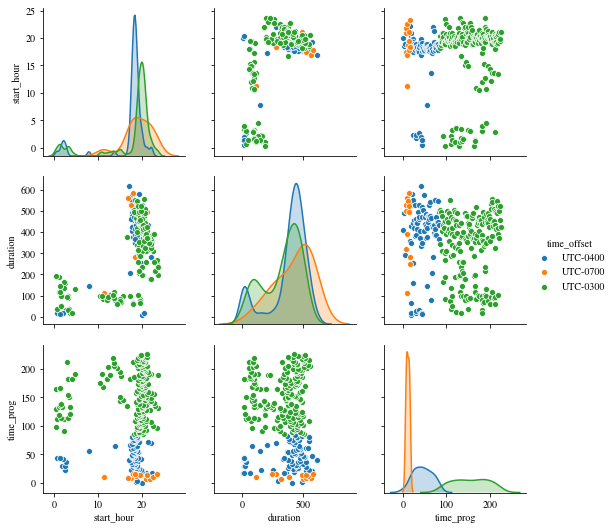

In [34]:
#Select relevant columns and make corner plot.
pair_cols = ['start_hour', 'duration', 'time_prog', 'time_offset']
df2 = data[pair_cols]
g = sns.pairplot(df2, hue='time_offset')

## Analyse sleep based on days since timezone change

In [35]:
print(data['time_offset'].values[0:10])

['UTC-0400' 'UTC-0400' 'UTC-0400' 'UTC-0700' 'UTC-0700' 'UTC-0700'
 'UTC-0700' 'UTC-0700' 'UTC-0700' 'UTC-0700']


In [109]:
print(data.time_offset[0:10])
print(data.time_prog[0:10])
print(data.time_offset.shift(1)[0:5])
print(data.time_offset.shift(2)[0:5])

26     UTC-0400
175    UTC-0400
43     UTC-0400
116    UTC-0700
167    UTC-0700
134    UTC-0700
189    UTC-0700
123    UTC-0700
258    UTC-0700
210    UTC-0700
Name: time_offset, dtype: object
26      0.000000
175     1.936806
43      3.953472
116     6.163194
167     7.198611
134     8.020139
189     8.993056
123     9.759722
258    10.230556
210    12.066667
Name: time_prog, dtype: float64
26          NaN
175    UTC-0400
43     UTC-0400
116    UTC-0400
167    UTC-0700
Name: time_offset, dtype: object
26          NaN
175         NaN
43     UTC-0400
116    UTC-0400
167    UTC-0400
Name: time_offset, dtype: object


In [86]:
#The following doesn't work because the time between entries is not always 1d.
#Check if timezone has changed in the day before.
data['tz_change_1d'] = data.time_offset != data.time_offset.shift(1)
#Set first element to false as it is compared to NaN.
data['tz_change_1d'].iloc[0] = False

#Check if timezone has changed 3 days ago and then remaind the same.
data['tz_change_3d'] = (
  (data.time_offset == data.time_offset.shift(1))
  & (data.time_offset == data.time_offset.shift(2))
  & (data.time_offset != data.time_offset.shift(3)))
#Set first three elements to false as they are compared to NaN.
data['tz_change_3d'].iloc[0:3] = False


In [127]:
#Compute number of days since time zone change.
time_since = 0.
tz_duration = []

for ((index2,row2),(index1,row1)) in zip(data.shift(1).iterrows(),data.iterrows()):
    if row1['time_offset'] == row2['time_offset']:
        time_since += (row1['time_prog'] - row2['time_prog']) #Additional time transpired since the tz changed.
    else:
        time_since = 0.
    tz_duration.append(time_since)

tz_duration = np.array(tz_duration)    
    
data['tz_duration'] = tz_duration

#We don't know for how long the person had been on the initial time zone.
data['tz_duration'].iloc[0:3] = np.nan

#We do not need tz_duration to be fine for plotting purposes.
def coarsify_duration(x):
    if abs(x - 0.) < 1.e-5:
        return 0
    elif (x > 0.) and (x<=1.5):
        return 1
    elif (x > 1.5) and (x <= 3.5):
        return 3
    elif (x > 3.5) and (x < 7.5):
        return 7
    elif x > 7.5:
        return 10

data['tz_coarse_duration'] = data['tz_duration'].apply(lambda x: coarsify_duration(x))

(270, 21)
(267, 21)


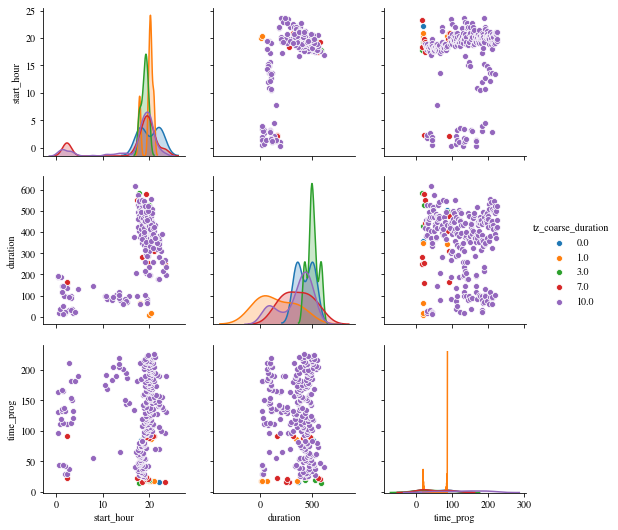

In [129]:
#Select relevant columns and make corner plot.
pair_cols = ['start_hour', 'duration', 'time_prog', 'tz_coarse_duration']
df2 = data[pair_cols]
df2.dropna(subset=['tz_coarse_duration'])
g = sns.pairplot(df2, vars=['start_hour', 'duration', 'time_prog'], hue='tz_coarse_duration')